Contray too the first version of the Gj674 SED, we're now taking the G430L spetrum as flux calibrated and scaling the G230l to it.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [15]:
g230l = Table.read('../test_files/components/hlsp_muscles_hst_stis_gj674_g230l_v1_component-spec.ecsv')
nw, nf, ndq = g230l['WAVELENGTH'], g230l['FLUX'], g230l['DQ']
g430l = fits.getdata('../STIS/odlm21010_sx1.fits')[0]
ow, of, odq = g430l['WAVELENGTH'], g430l['FLUX'], g430l['DQ']

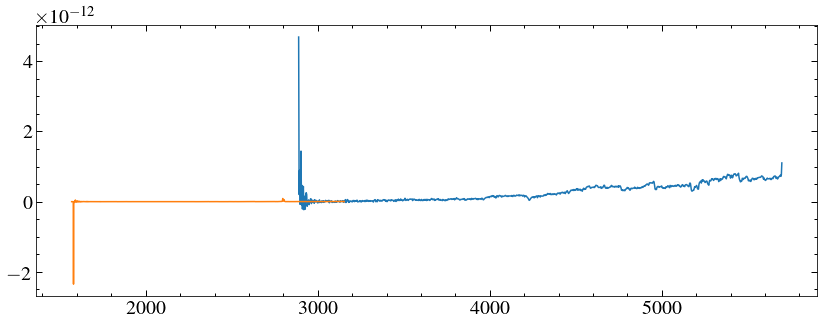

In [9]:
plt.plot(ow, of,nw,nf)

Ok some overlap but it gets noisy, yay

(-1e-13, 2e-13)

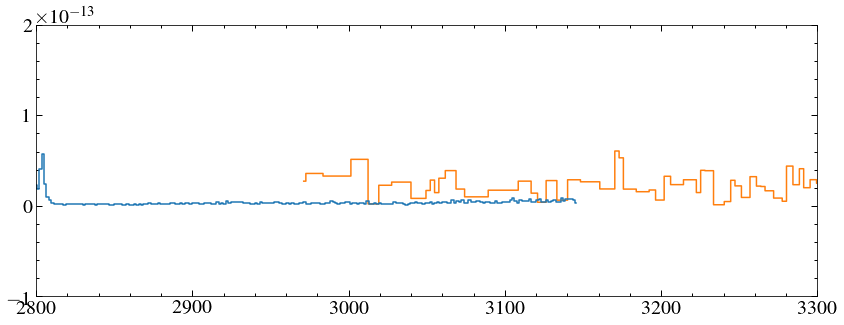

In [18]:
plt.step(nw[ndq==0], nf[ndq==0], where='mid')
plt.step(ow[odq==0], of[odq==0], where='mid', zorder=-1)
plt.xlim(2800, 3300)
plt.ylim(-1e-13, 2e-13)

Looks reasonable

In [51]:
def find_stis_normfac(nw, nf, ndq, ow, of, odq):
    """
    Finds the normaliastion factor between the COS FUV data and the STIS G140L spectrum, if present
    """
   # g140l = Table.read(glob.glob(component_repo+'*g140l*.ecsv')[0])
   # g130m = Table.read(glob.glob(component_repo+'*g130m*.ecsv')[0])
   # cw, cf, cdq = g130m['WAVELENGTH'], g130m['FLUX'], g130m['DQ']
   # sw, sf, sdq = g140l['WAVELENGTH'], g140l['FLUX'], g140l['DQ']
    cw, cf, cdq = ow, of, odq
    sw, sf, sdq = nw, nf, ndq
    c_mask = (cw >= sw[0]) & (cw <=sw[-1]) & (cdq == 0)
    s_mask = (sw >= cw[0]) & (sw <=cw[-1]) & (sdq == 0)#mask to same same waveband and cut dq flags
    cw, cf, sw, sf = cw[c_mask], cf[c_mask], sw[s_mask], sf[s_mask]
    cw1, cf1 = resample.bintogrid(cw, cf, newx=sw) #rebin to stis wavelength grid
   # stis_airglow_mask = mask_maker(sw, airglow)
    #cos_airglow_mask = mask_maker(cw1, airglow)
    #sw, sf, cw1, cf1 = sw[stis_airglow_mask], sf[stis_airglow_mask], cw1[cos_airglow_mask], cf1[cos_airglow_mask] #remove airglow
    c_int = np.trapz(cf1,cw1)
    s_int =  np.trapz(sf,sw)
    normfac = c_int/s_int
    print('STIS normfac = ', normfac)
    return normfac

normfac = find_stis_normfac(nw, nf, ndq, ow, of, odq)

STIS normfac =  4.208617438255892


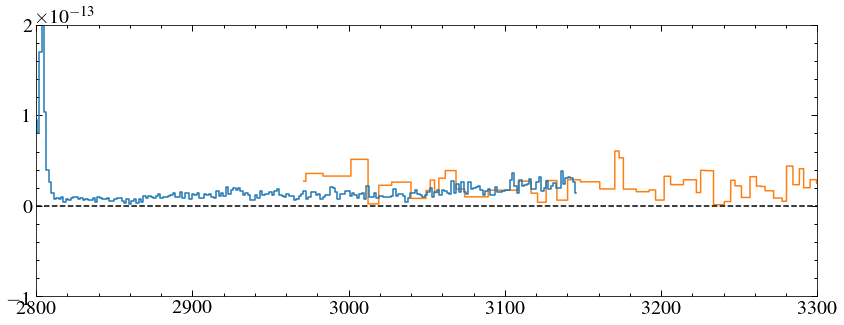

In [52]:
plt.step(nw[ndq==0], nf[ndq==0]*normfac, where='mid')
plt.step(ow[odq==0], of[odq==0], where='mid', zorder=-1)
plt.xlim(2800, 3300)
plt.ylim(-1e-13, 2e-13)
plt.axhline(0, c='k', ls='--')

Looks good. Little high though. How does it line up the other end?

In [46]:
g140l = Table.read('../test_files/components/hlsp_muscles_hst_stis_gj674_g140l_v1_component-spec.ecsv')

In [47]:
fw, ff, fdq = g140l['WAVELENGTH'], g140l['FLUX'], g140l['DQ']
f_norm = g140l.meta['NORMFAC']
print(f_norm)

3.0697155334922224


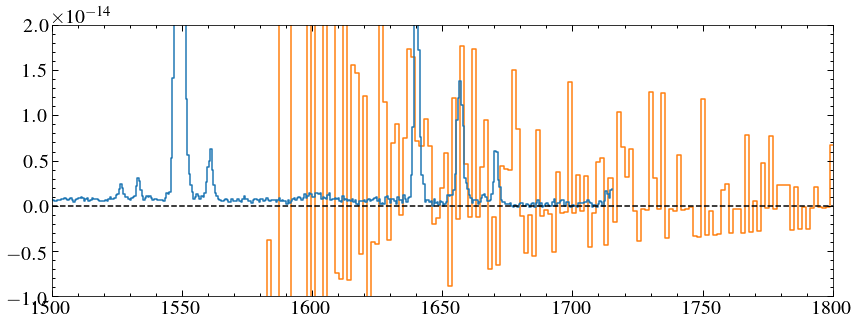

In [53]:
plt.step(fw, ff*f_norm, where='mid')
plt.step(nw[ndq==0], nf[ndq==0]*normfac, where='mid', zorder=-1)
plt.xlim(1500, 1800)
plt.ylim(-1e-14, 2e-14)
plt.axhline(0, c='k', ls='--')

Hard to tell but looks fine. How does the log plot look?

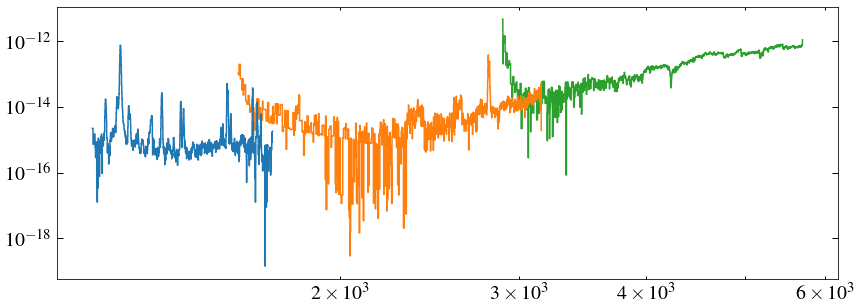

In [54]:
plt.step(fw[ff>0], ff[ff>0]*f_norm, where='mid')
plt.step(nw[nf>0], nf[nf>0]*normfac, where='mid', zorder=-1)
plt.step(ow[of>0], of[of>0], where='mid', zorder=-2)
plt.xscale('log')
plt.yscale('log')

Awful, that's what- bit better with fixed fuv scaling

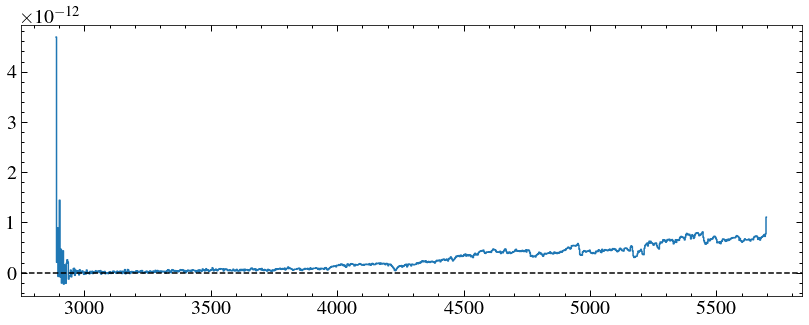

In [39]:
plt.step(ow, of, where='mid', zorder=-2)
plt.axhline(0, c='k', ls='--')

In [63]:
#print(f_norm)
normfac2 = find_stis_normfac(nw[10:], nf[10:], ndq[10:], fw, ff*f_norm, fdq)

STIS normfac =  0.8270818156967695


Oh it's that bit on the end

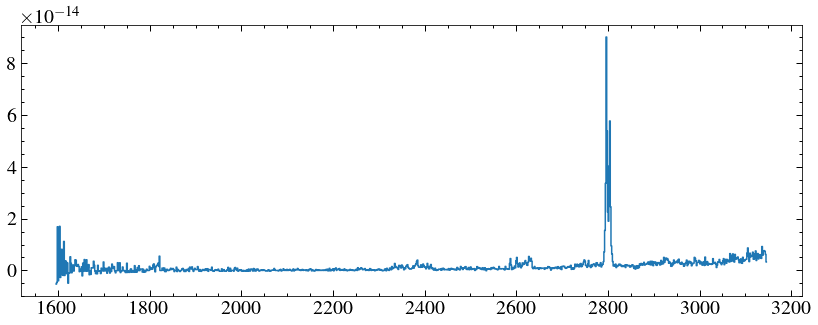

In [62]:
plt.step(nw[ndq==0][10:], nf[ndq==0][10:], where='mid')

Hmm.